<a href="https://colab.research.google.com/github/NeSma237/road_extraction_dataset/blob/main/road_extraction_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/deepglobe-road-extraction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/deepglobe-road-extraction-dataset


In [ ]:
import os
print(os.listdir(path)[:5])

['class_dict.csv', 'valid', 'metadata.csv', 'test', 'train']


In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np

IMG_SIZE = 128
BATCH_SIZE = 8

def load_image_mask(image_path, mask_path):

    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize


    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = (mask > 127).astype(np.float32)  # Binary mask
    mask = np.expand_dims(mask, axis=-1)  # Add channel dim

    return image, mask



In [ ]:
def get_dataset_from_combined_folder(folder_path):
    image_paths = []
    mask_paths = []

    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('_sat.jpg'):
            image_path = os.path.join(folder_path, filename)
            mask_name = filename.replace('_sat.jpg', '_mask.png')
            mask_path = os.path.join(folder_path, mask_name)

            if os.path.exists(mask_path):
                image_paths.append(image_path)
                mask_paths.append(mask_path)

    def generator():
        for img_path, msk_path in zip(image_paths, mask_paths):
            yield load_image_mask(img_path, msk_path)

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([IMG_SIZE, IMG_SIZE, 3], [IMG_SIZE, IMG_SIZE, 1])
    )

    return dataset.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_dataset = get_dataset_from_combined_folder(os.path.join(path, "train"))
valid_dataset = get_dataset_from_combined_folder(os.path.join(path, "valid"))

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [ ]:
for img, mask in train_dataset.take(1):
    print("Image shape:", img[0].shape)
    print("Mask shape:", mask[0].shape)

Image shape: (128, 128, 3)
Mask shape: (128, 128, 1)


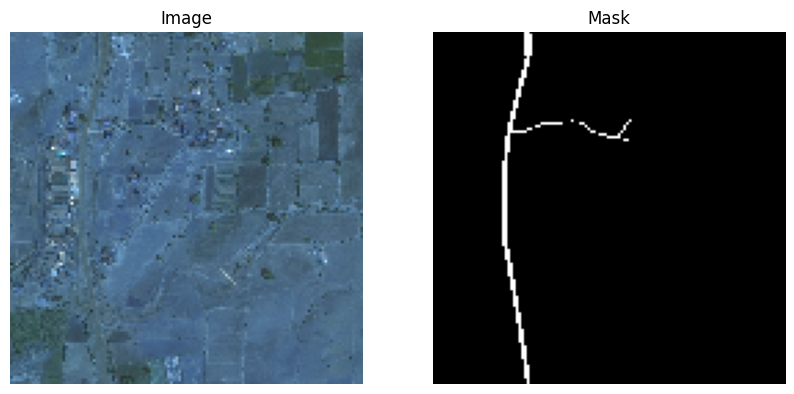

In [ ]:
import matplotlib.pyplot as plt

for img, mask in train_dataset.take(1):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img[0])
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask[0, :, :, 0], cmap='gray')
    plt.title("Mask")
    plt.axis("off")
    plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    #(Encoder)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    #Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #(Decoder)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    #Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ dropout_3[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]  

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [ ]:
model.compile(optimizer='adam', loss=dice_loss,metrics=['accuracy', dice_coefficient, iou_metric])

In [ ]:
model.fit(train_dataset,validation_data=valid_dataset,epochs=25)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


    779/Unknown 283s 318ms/step - accuracy: 0.6774 - dice_coefficient: 0.1740 - iou_metric: 0.0969 - loss: 0.8260

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


779/779 ━━━━━━━━━━━━━━━━━━━━ 283s 319ms/step - accuracy: 0.6776 - dice_coefficient: 0.1741 - iou_metric: 0.0970 - loss: 0.8259
Epoch 2/25
779/779 ━━━━━━━━━━━━━━━━━━━━ 170s 215ms/step - accuracy: 0.9282 - dice_coefficient: 0.3440 - iou_metric: 0.2097 - loss: 0.6560
Epoch 3/25
779/779 ━━━━━━━━━━━━━━━━━━━━ 173s 219ms/step - accuracy: 0.9441 - dice_coefficient: 0.4219 - iou_metric: 0.2693 - loss: 0.5781
Epoch 4/25
779/779 ━━━━━━━━━━━━━━━━━━━━ 198s 213ms/step - accuracy: 0.9505 - dice_coefficient: 0.4663 - iou_metric: 0.3062 - loss: 0.5337
Epoch 5/25
779/779 ━━━━━━━━━━━━━━━━━━━━ 202s 256ms/step - accuracy: 0.9535 - dice_coefficient: 0.4917 - iou_metric: 0.3283 - loss: 0.5083
Epoch 6/25
779/779 ━━━━━━━━━━━━━━━━━━━━ 229s 214ms/step - accuracy: 0.9563 - dice_coefficient: 0.5128 - iou_metric: 0.3472 - loss: 0.4872
Epoch 7/25
779/779 ━━━━━━━━━━━━━━━━━━━━ 202s 256ms/step - accuracy: 0.9575 - dice_coefficient: 0.5265 - iou_metric: 0.3596 - loss: 0.4735
Epoch 8/25
779/779 ━━━━━━━━━━━━━━━━━━━━ 229s 